In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [113]:
class Network(nn.Module):

  def __init__(self, input, width, depth, output):
    super().__init__()

    # activation function
    activation = nn.Tanh

    # input layer
    self.fci = nn.Sequential(*[nn.Linear(input, depth), activation()])

    # hidden layers
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(depth, depth), activation()]) for i in range(width-1)])

    # output layer
    self.fco = nn.Linear(depth, output)

  # forward propagation
  def forward(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    return x
  
  # exact solution of modelling coursework
  def TransientAnalyticSoln(self, x_rms, t_rms):

    sol = []
    for i in range(len(x_rms)):
      x = x_rms[i]
      t = t_rms[i]  
      trans = 0
      for k in range(1, 1001):
          trans += ((((-1)**k)/k) * np.exp(-k**2*np.pi**2*t)*np.sin(k*np.pi*x))
      c = x + (2/np.pi)*trans
      sol.append(c)
    return sol
  
  def init_boundaries(self):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    x0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
    x1_boundary = torch.tensor(1.).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(30).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
    x_boundary = torch.rand(30).view(-1, 1).requires_grad_(True).to(device)

    return x0_boundary, x1_boundary, t_boundaries, t0_boundary, x_boundary
  
  def physics_sample(self):
      
      # sample points for training
      x = torch.rand(30).view(-1, 1).requires_grad_(True).to(device)
      t = torch.rand(30).view(-1, 1).requires_grad_(True).to(device)
  
      return x, t
  
  def rms_sample(self):
        
        # sample points for training
        x = torch.rand(30).view(-1, 1).requires_grad_(True).to(device)
        t = torch.rand(30).view(-1, 1).requires_grad_(True).to(device)
    
        return x, t
  
  def c_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(r).to(device), create_graph=True)[0]
  
  def c_rr(self, c, r):
    c_r = self.c_r(c, r)
    return torch.autograd.grad(c_r, r, grad_outputs=torch.ones_like(c_r).to(device), create_graph=True)[0]
  
  def c_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def losses(self, x_rms, t_rms, c_analytic, D):

    x0_boundary, x1_boundary, t_boundaries, t0_boundary, x_boundary = self.init_boundaries()
    x_phys, t_phys = self.physics_sample()

    # losses for x and t boundaries
    x0_loss = torch.empty(0).to(device)
    for t in t_boundaries:
      t = t.unsqueeze(1)
      c = self.forward(x0_boundary, t)
      x0_loss = torch.cat((x0_loss, c**2), 0)
    
    x1_loss = torch.empty(0).to(device)
    for t in t_boundaries:
      t = t.unsqueeze(1)
      c = self.forward(x1_boundary, t)
      x1_loss = torch.cat((x1_loss, (c-1)**2), 0)
    
    t0_loss = torch.empty(0).to(device)
    for x in x_boundary:
      x = x.unsqueeze(1)
      c = self.forward(x, t0_boundary)
      t0_loss = torch.cat((t0_loss, c**2), 0)

    # loss for physics sample
    phys_loss = torch.empty(0).to(device)
    for i in range(len(x_phys)):

      x = x_phys[i].view(-1, 1)
      t = t_phys[i].view(-1, 1)

      c = self.forward(x, t)
      c_rr = self.c_rr(c, x)
      c_t = self.c_t(c, t)

      phys_loss = torch.cat((phys_loss, (c_t - D*c_rr)**2), 0)
    
    rms_loss = torch.empty(0).to(device)
    for i in range(len(x_rms)):
      c = self.forward(x_rms[i].view(-1, 1), t_rms[i].view(-1, 1))
      rms_loss = torch.cat((rms_loss, (c - c_analytic[i])**2), 0)
    

    loss = 1e-2 * (torch.mean(x0_loss) + torch.mean(x1_loss) + torch.mean(t0_loss) + torch.mean(phys_loss)) + torch.mean(rms_loss)  

    return loss
  
  def train(self, epochs, lr):

    # get analytical solution for training
    x_rms, t_rms = self.rms_sample()
    c_analytic = torch.tensor(self.TransientAnalyticSoln(x_rms.detach().numpy(), t_rms.detach().numpy())).to(device)

    # initialise parameters and optimiser
    D = torch.nn.Parameter(torch.tensor(0.).to(device), requires_grad=True)
    Ds = [] 
    losses = []
    optimizer = torch.optim.Adam(list(self.parameters()) + [D], lr = lr)
    

    for epoch in range(epochs):
      
      optimizer.zero_grad()
      # find loss
      loss = self.losses(x_rms, t_rms, c_analytic, D)

      # store parameter and loss values
      Ds.append(D.item())
      losses.append(loss.item())
      # backpropagation
      loss.backward()
      optimizer.step()
      # print loss and parameter values
      print(f'Epoch: {epoch}  Loss: {loss.item()}, D: {D.item()}', end='\r')

      if epoch % 33333 == 0:
        self.plot()

    return Ds, losses

  def plot(self):
      
      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      
      C = np.zeros((len(X), len(T)))
      for i in range(len(X)):
        x = X[i].view(-1, 1)
        for j in range(len(T)):
          t = T[j].view(-1, 1)
          c = self.forward(x, t)
          C[i, j] = c.item()
      
      X, T = np.meshgrid(X.detach().numpy(), T.detach().numpy())
      fig = plt.figure()
      fig.clear()
      ax = fig.add_subplot(111, projection='3d')
      ax.plot_surface(X, T, C, cmap='viridis')
      
      plt.show()
  


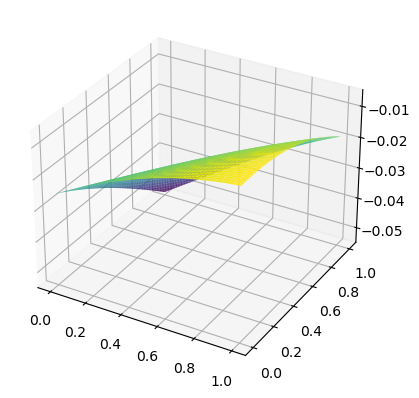

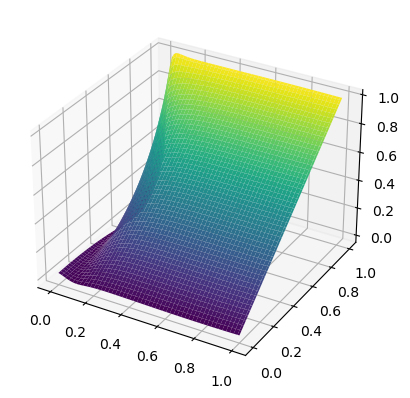

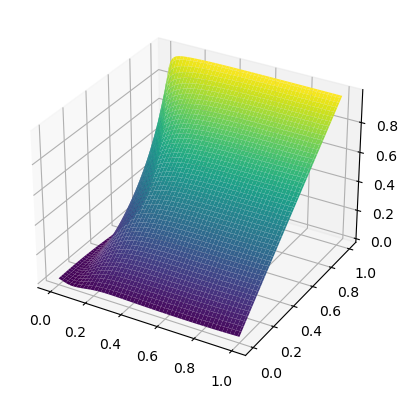

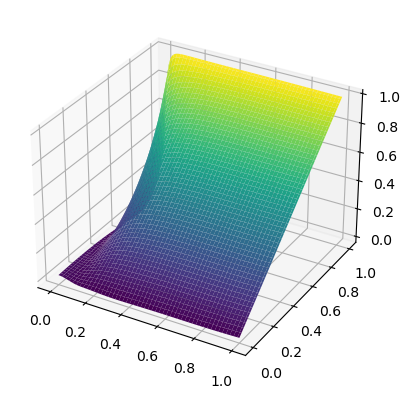

In [114]:
# nn seed
torch.manual_seed(123)

# define nn to train, two inputs for x and t
pinn = Network(2, 3, 32, 1).to(device)

# training things
epochs = 100000
lr = 1e-3


Ds, losses = pinn.train(epochs, lr)

1.0151629447937012

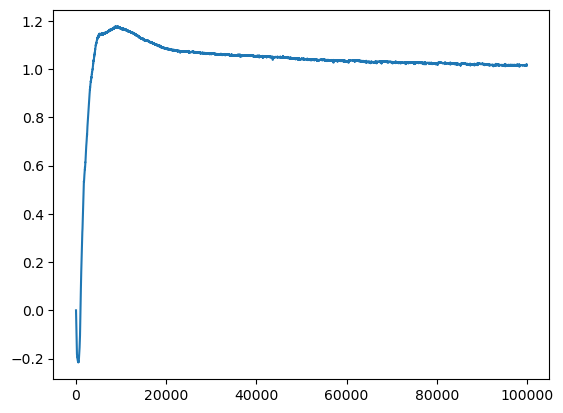

In [117]:
plt.plot(Ds)
Ds[-1]

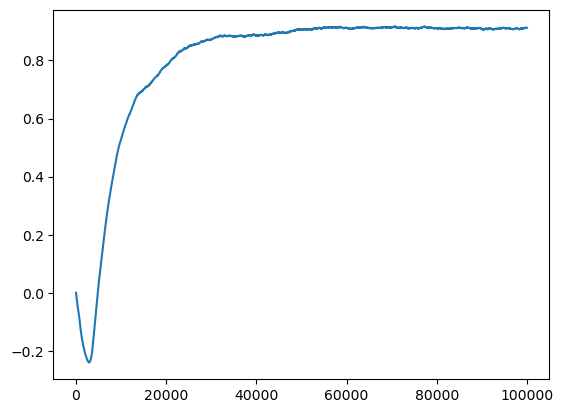

In [36]:
# ds_flattened = [tensor.flatten().detach().numpy() for tensor in Ds]

# plot Ds
plt.plot(Ds)
plt.show()

ValueError: Contour levels must be increasing

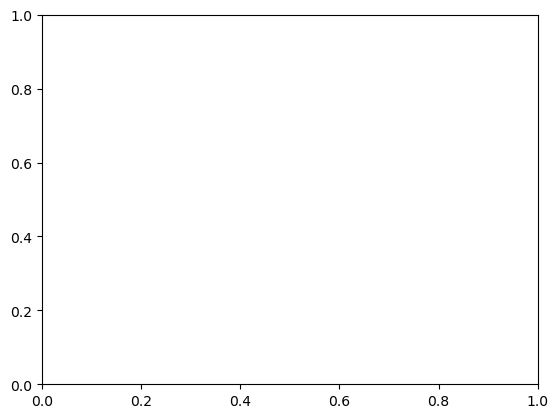

In [8]:
X = torch.linspace(0, 5e-6, 50).to(device)
T = torch.linspace(0, 400, 50).to(device)
X, T = np.meshgrid(X.cpu().numpy(), T.cpu().numpy())